Сейчас я попробую классифицировать тексты через нейросеть.
Воспользуюсь признаками из КаунтВекторайзера

In [0]:
import numpy as np
import pandas as pd
from nltk.tokenize import wordpunct_tokenize



In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight



In [4]:
import keras
from keras.models import Sequential
from keras import layers
import tensorflow as tf
from keras.layers import Dense,Activation,Layer,Lambda



Using TensorFlow backend.


Я пользовалась вот этими статьями, комменты из них:

https://realpython.com/python-keras-text-classification/

https://www.kaggle.com/parasjindal96/basic-deep-learning-tutorial-using-keras

https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/

https://www.dlology.com/blog/how-to-use-keras-sparse_categorical_crossentropy/

In [5]:
df_features = pd.read_csv('gk4z_features.csv')
df_features.head()

,id,text,likes,label,len_char,punct,punct_count,punct%,tokens,tokens_count,tokens%,smiles,smiles_count,smiles%,numbers_count,numbers%,latin_count,latin%
0,76000,#конкурс@the4gkz \r\r\r\nДля вашего удобства с...,17,post,503,"#@.:•|-.—:./:./•|-.—/:./:://./|://./•|.—:./:.,!",47,0.093439,"['#', 'конкурс', '@', 'the4gkz', 'Для', 'вашег...",81,0.161034,NaN,0,0.000000,23,0.045726,116,0.230616
1,76914,Уже сегодня ночью (по МСК) начнётся один из са...,34,post,669,"()—.—()!..,!(),—(,).:://..//",28,0.041854,"['Уже', 'сегодня', 'ночью', '(', 'по', 'МСК', ...",111,0.165919,NaN,0,0.000000,0,0.000000,49,0.073244
2,76917,"Ого, Нина Кравиц в лайн-апе😲",0,comment,28,",-",2,0.071429,"['Ого', ',', 'Нина', 'Кравиц', 'в', 'лайн-апе😲']",6,0.214286,😲,1,0.035714,0,0.000000,0,0.000000
3,76920,"[id17823823|Анастасия], с новым крутым шоу от ...",0,comment_to_comment,56,"[|],",4,0.071429,"['[', 'id17823823|Анастасия', ']', ',', 'с', '...",11,0.196429,NaN,0,0.000000,8,0.142857,2,0.035714
4,76922,Скину расписание на сегодня сюда. Время москов...,0,comment,687,..:......&....:..........:......&.....,38,0.055313,"['Скину', 'расписание', 'на', 'сегодня', 'сюда...",112,0.163028,NaN,0,0.000000,127,0.184862,332,0.483261


In [0]:
# заменяет строки на цифры. Классы для модели должны быть обязательно в виде чисел.
def mapping(data,feature):
    featureMap=dict()
    count=0
    for i in sorted(data[feature].unique(),reverse=True):
        featureMap[i]=count
        count=count+1
    data[feature]=data[feature].map(featureMap)
    return data
# Map values of Series according to input correspondence.
#Used for substituting each value in a Series with another value, that may be derived from a function, a dict or a Series.

In [0]:
df_features=mapping(df_features,feature="label")
# 0 - post, 1 - comment_to_comment. 2 - comment

In [8]:
df_features.head()

,id,text,likes,label,len_char,punct,punct_count,punct%,tokens,tokens_count,tokens%,smiles,smiles_count,smiles%,numbers_count,numbers%,latin_count,latin%
0,76000,#конкурс@the4gkz \r\r\r\nДля вашего удобства с...,17,0,503,"#@.:•|-.—:./:./•|-.—/:./:://./|://./•|.—:./:.,!",47,0.093439,"['#', 'конкурс', '@', 'the4gkz', 'Для', 'вашег...",81,0.161034,NaN,0,0.000000,23,0.045726,116,0.230616
1,76914,Уже сегодня ночью (по МСК) начнётся один из са...,34,0,669,"()—.—()!..,!(),—(,).:://..//",28,0.041854,"['Уже', 'сегодня', 'ночью', '(', 'по', 'МСК', ...",111,0.165919,NaN,0,0.000000,0,0.000000,49,0.073244
2,76917,"Ого, Нина Кравиц в лайн-апе😲",0,2,28,",-",2,0.071429,"['Ого', ',', 'Нина', 'Кравиц', 'в', 'лайн-апе😲']",6,0.214286,😲,1,0.035714,0,0.000000,0,0.000000
3,76920,"[id17823823|Анастасия], с новым крутым шоу от ...",0,1,56,"[|],",4,0.071429,"['[', 'id17823823|Анастасия', ']', ',', 'с', '...",11,0.196429,NaN,0,0.000000,8,0.142857,2,0.035714
4,76922,Скину расписание на сегодня сюда. Время москов...,0,2,687,..:......&....:..........:......&.....,38,0.055313,"['Скину', 'расписание', 'на', 'сегодня', 'сюда...",112,0.163028,NaN,0,0.000000,127,0.184862,332,0.483261


In [0]:
#Разделяем датасет на обучающий и проверочный
X = df_features['text'].values
y = df_features['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20)

In [0]:
vectorizer = CountVectorizer(tokenizer=wordpunct_tokenize) # использую токенайзер, который учитывает все знаки препинания
vectorizer.fit(X)

X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)
X_train

<42150x68660 sparse matrix of type '<class 'numpy.int64'>'
	with 509228 stored elements in Compressed Sparse Row format>

42150 - the number of training samples we have after the train-test split

68660 - the size of the vocabulary

In [0]:
y_train.shape

(42150,)

In [0]:
# Before we build our model, we need to know the input dimension of our feature vectors. 
#This happens only in the first layer since the following layers can do automatic shape inference.
input_dim = X_train.shape[1]

In [0]:
#Keras supports two main types of models. Sequential model (usual, simple) and the functional (advanced)
#The Sequential model is a linear stack of layers. The most common layer is the Dense layer 
#which is your regular densely connected neural network layer with all the weights and biases.
#model = Sequential()

In [0]:
# In order to build the Sequential model, you can add layers one by one in order as follows:
# model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
# 10 - number of nodes (hidden units) in layer
#  It is generally common to use a rectified linear unit (ReLU) for hidden layers, 
#  and softmax function for the output layer of multi-class classification problems.

Чтобы удобнее пробовать разное количество слоев и нейронов, слямзим функцию, которая позволяет это делать. На вход она будет получать список.

Первый элемент списка - это  input dimension of our feature vectors ( the size of the vocabulary, если речь идет о матрице, которую возвращает CountVectorizer.transform ). 

Последний элемент списка - это количество нейронов, которые находятся в последнем слое -  это в нашем случае количество возможных классов, т.е. 3: в качестве функции активации в последнем слое мы юзаем softmax, она возвращает вероятность принадлежности наших текстов к каждому из классов, т.е. список из трех чисел, которые в сумме дают единицу.

Количество элементов посередине - это количество слоёв в сетке, значение элемента - это число нейронов в слое.

In [0]:
def getModel(arr):
    model=Sequential()
    for i in range(len(arr)):
        if i!=0 and i!=len(arr)-1:
            if i==1:
                model.add(Dense(arr[i],input_dim=arr[0],kernel_initializer='normal', activation='relu')) # первый слой
            else:
                model.add(Dense(arr[i],activation='relu')) # второй и последующий слои
    model.add(Dense(arr[-1], activation=tf.nn.softmax)) # последний слой
    model.compile(loss="sparse_categorical_crossentropy",optimizer='rmsprop',metrics=['sparse_categorical_accuracy'])
    return model

При компиляции мы используем sparse_categorical_crossentropy: the conventional way is to have the target outputs converted to the one-hot encoded array to match with the output shape, however, with the help of the sparse_categorical_crossentropy loss function, we can skip that step and keep the integers as targets.

И еще слямзим код, который показывает функцию потерь в реальном времени:

In [0]:

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

Я нигде не нашла какой-то конкретной инфы по поводу того, сколько слоев и нейронов использовать, везде пишут, что "смотря на каких данных", так что я буду пробовать и смотреть, что получается.

## 1

In [0]:
firstModel=getModel([input_dim,5,5,5,3])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
firstModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 343305    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 18        
Total params: 343,383
Trainable params: 343,383
Non-trainable params: 0
_________________________________________________________________


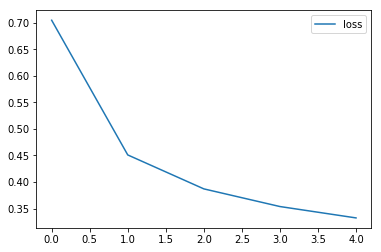

In [0]:
history = firstModel.fit(X_train, y_train, epochs=5, callbacks = [plot_losses])

In [0]:
test_loss, test_acc = firstModel.evaluate(X_test, y_test)

print('Точность на тестовом кусочке:', test_acc)

14050/14050 [==============================] - 5s 321us/step
Точность на тестовом кусочке: 0.8510320284697509


И я написала еще функцию, которая возвращает привычный classification report, потому что accuracy вообще ни о чем не говорит для несбалансированных данных

In [0]:
def classif_report(current_model):
    predY=current_model.predict(X_test) 
    new_ar = []
    for el in predY:
        new_ar.append(np.argmax(el))
    print(classification_report(y_test, new_ar))
  
  

In [0]:
classif_report(firstModel)

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      3476
           1       0.57      0.32      0.41      1170
           2       0.86      0.93      0.89      9404

   micro avg       0.85      0.85      0.85     14050
   macro avg       0.77      0.69      0.72     14050
weighted avg       0.84      0.85      0.84     14050



В общем-то, неплохой результат для комментов второго уровня.

## 2

In [0]:
secondModel=getModel([input_dim,30,60,20,3])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
secondModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                2059830   
_________________________________________________________________
dense_2 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 63        
Total params: 2,062,973
Trainable params: 2,062,973
Non-trainable params: 0
_________________________________________________________________


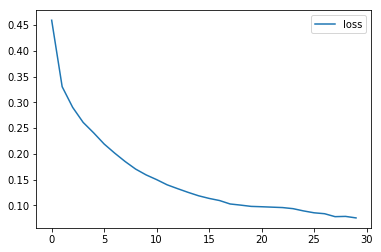

In [0]:
history = secondModel.fit(X_train, y_train, epochs=30, callbacks=[plot_losses])

In [0]:
classif_report(secondModel)

              precision    recall  f1-score   support

           0       0.85      0.74      0.79      3486
           1       0.39      0.48      0.43      1101
           2       0.85      0.87      0.86      9463

   micro avg       0.80      0.80      0.80     14050
   macro avg       0.70      0.70      0.69     14050
weighted avg       0.81      0.80      0.81     14050



чуть похуже результат, моделька переобучилась

## 3

In [0]:
thirdModel=getModel([input_dim,200,200,300,3])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
thirdModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               13732200  
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               60300     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 903       
Total params: 13,833,603
Trainable params: 13,833,603
Non-trainable params: 0
_________________________________________________________________


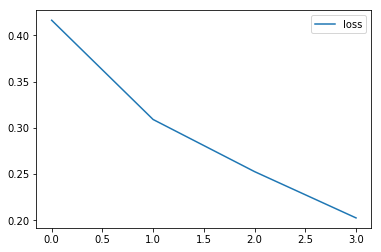

In [0]:
history = thirdModel.fit(X_train, y_train, epochs=4, callbacks=[plot_losses])

In [0]:
classif_report(thirdModel)

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3385
           1       0.62      0.43      0.51      1200
           2       0.88      0.92      0.90      9465

   micro avg       0.86      0.86      0.86     14050
   macro avg       0.79      0.73      0.75     14050
weighted avg       0.85      0.86      0.85     14050



весьма и весьма. И с комментами второго уровня справился хорошо. Но результат не особо выше, чем когда я классифицировала обычной логистической регрессией на каунтВекторайзере, который анализировал символьные биграммы (файл 04):

CountVectorizer(analyzer="char", ngram_range=(2,2))

хм. Может, здесь тоже воспользоваться такими параметрами векторайзера?

## 4

In [0]:
vectorizer = CountVectorizer(analyzer="char", ngram_range=(2,2)) 
vectorizer.fit(X)

X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)
X_train

<38877x8420 sparse matrix of type '<class 'numpy.int64'>'
	with 2079291 stored elements in Compressed Sparse Row format>

In [0]:
input_dim = X_train.shape[1]

In [0]:
forthModel=getModel([input_dim,5,5,5,3])

In [0]:
forthModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 42105     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 18        
Total params: 42,183
Trainable params: 42,183
Non-trainable params: 0
_________________________________________________________________


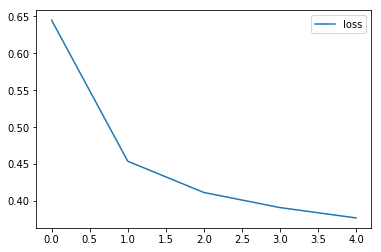

In [0]:
history = forthModel.fit(X_train, y_train, epochs=5, callbacks=[plot_losses])

In [0]:
classif_report(forthModel)

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      3462
           1       0.52      0.32      0.40      1145
           2       0.87      0.91      0.89      9443

   micro avg       0.85      0.85      0.85     14050
   macro avg       0.75      0.69      0.71     14050
weighted avg       0.84      0.85      0.84     14050



может, пообучать её чуть побольше?

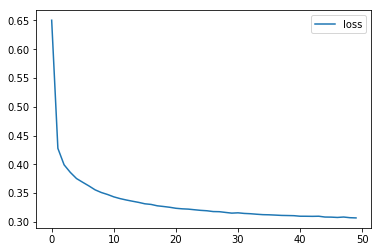

In [0]:
history = forthModel.fit(X_train, y_train, epochs=50, callbacks=[plot_losses])

In [0]:
classif_report(forthModel)

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      3462
           1       0.47      0.45      0.46      1145
           2       0.87      0.90      0.88      9443

   micro avg       0.84      0.84      0.84     14050
   macro avg       0.74      0.72      0.73     14050
weighted avg       0.84      0.84      0.84     14050



От большего количества эпох толку нет. Попробую увеличить количество нейронов.

## 5

In [0]:
fifthModel = getModel([input_dim,100,100,50,3])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
fifthModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               842100    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 153       
Total params: 857,403
Trainable params: 857,403
Non-trainable params: 0
_________________________________________________________________


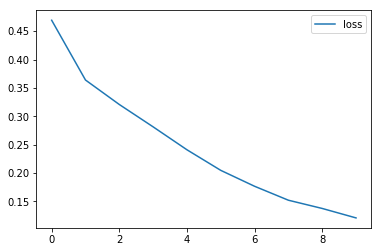

In [0]:
history = fifthModel.fit(X_train, y_train, epochs=10, callbacks=[plot_losses])

In [0]:
classif_report(fifthModel)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3361
           1       0.50      0.37      0.42      1161
           2       0.86      0.89      0.87      8437

   micro avg       0.83      0.83      0.83     12959
   macro avg       0.73      0.70      0.71     12959
weighted avg       0.82      0.83      0.82     12959



Да, результат такой же. Теперь я хочу посмотреть, какие именно тексты показались трудными классификатору, что он их неправильно распознал. Для этого, видимо, мне придется разделить тексты на трейн и тест по-новому.

## 6

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df_features.text, df_features.label, random_state=20)

In [0]:
vectorizer = CountVectorizer(analyzer="char", ngram_range=(2,2)) 
vectorizer.fit(df_features.text)

X_train = vectorizer.transform(x_train)
X_test  = vectorizer.transform(x_test)
X_train

<38877x8420 sparse matrix of type '<class 'numpy.int64'>'
	with 2075986 stored elements in Compressed Sparse Row format>

In [0]:
input_dim = X_train.shape[1]

In [0]:
sixthModel = getModel([input_dim,200,200,200,3])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
sixthModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               1684200   
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 603       
Total params: 1,765,203
Trainable params: 1,765,203
Non-trainable params: 0
_________________________________________________________________


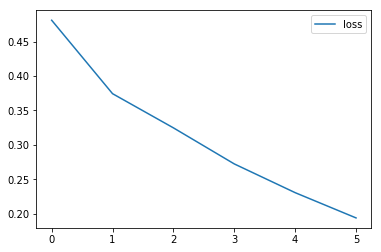

In [0]:
history = sixthModel.fit(X_train, y_train, epochs=6, callbacks=[plot_losses])

В этот момент я немного переписала функцию classif_report, чтобы она возвращала еще и аррей с предсказанными классами.

In [0]:
def classif_report(current_model):
    predY=current_model.predict(X_test) 
    new_ar = []
    for el in predY:
        new_ar.append(np.argmax(el))
    print(classification_report(y_test, new_ar))
    return new_ar

In [0]:

predY = classif_report(sixthModel)

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3370
           1       0.57      0.35      0.43      1094
           2       0.87      0.89      0.88      8495

   micro avg       0.84      0.84      0.84     12959
   macro avg       0.75      0.70      0.72     12959
weighted avg       0.83      0.84      0.83     12959



Сделаю датафрейм, в котором смогу посмотреть, какие тексты классифицировались правильно, а какие нет.

In [0]:
analize_df = pd.DataFrame(x_test).reset_index()
analize_df['y_true'] = y_test.array
analize_df['y_pred'] = predY
analize_df['result'] = analize_df.apply(lambda x: x['y_true']==x['y_pred'], axis = 1)
analize_df
# 0 - post, 1 - comment_to_comment. 2 - comment

,index,text,y_true,y_pred,result
0,7805,почему у пилотов столько фанатов а очевидную л...,0,0,True
1,30271,Ого опять,2,2,True
2,26836,Вот за Тома сейчас обидно было,2,2,True
3,47225,правда ли что все музыканты делающие на концер...,0,0,True
4,26077,Смотреть концерт без загораживающих обзор смар...,2,0,False
5,44795,скорее бы вышла группа я хоть забуду что устал,0,2,False
6,4732,"Как пойти с радужным флагом, чтоб тебя не побили",2,2,True
7,7799,"Топлю за Wonderful Life, хотя Мантра тоже непл...",2,2,True
8,5965,"Єєєє, Florence + The Machine",2,2,True
9,47158,люблю вокалистку но я чмо что делать,0,0,True


In [0]:
# 0 - post, 1 - comment_to_comment. 2 - comment
analize_df[analize_df['result']==False]

,index,text,y_true,y_pred,result
4,26077,Смотреть концерт без загораживающих обзор смар...,2,0,False
5,44795,скорее бы вышла группа я хоть забуду что устал,0,2,False
15,6677,"[id289378389|Fatal], Ярославль очень приличный...",1,2,False
25,7657,"[id401020082|Иван], ты думал они выпустят очер...",1,2,False
36,20769,Потому что они делают всю dirty work,2,0,False
41,17578,Именно поэтому к концертному сезону купила поя...,2,0,False
46,12195,"[id10723909|Vanya], ахахахха, я просто не помн...",1,2,False
47,32156,Когда сначала негодовал что два концерта в оди...,2,0,False
48,1479,"""Главный гитарист 21 века"" как интересно это г...",2,0,False
55,7095,"[id156904779|Елена], молодежи в этой очереди н...",1,2,False


Судя по датафрейму, нейросетка так и не смогла уловить, что тексты, начинающиеся с  " [id12345678....]"    относятся к комментам второго уровня. Неужели это настолько сложно?  Попробую добавить веса, чтобы нейросеть уделяла больше внимания комментам второго уровня.
Про веса читала вот здесь:
https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras/42534#42534

## 7.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(df_features.text, df_features.label)

In [10]:
vectorizer = CountVectorizer(analyzer="char", ngram_range=(2,2)) 
vectorizer.fit(df_features.text)

X_train = vectorizer.transform(x_train)
X_test  = vectorizer.transform(x_test)
X_train

<38877x8420 sparse matrix of type '<class 'numpy.int64'>'
	with 2078182 stored elements in Compressed Sparse Row format>

In [0]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [12]:
class_weights
# 0 - post, 1 - comment_to_comment. 2 - comment
# всё верно, у комментов к комментам самый большой вес, у просто комментов - самый маленький, т.к. их больше всего.

array([1.27036565, 3.84768409, 0.51205153])

In [0]:
input_dim = X_train.shape[1]

In [0]:
sevensModel = getModel([input_dim,100,100, 100, 3])

In [22]:
sevensModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               842100    
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 303       
Total params: 862,603
Trainable params: 862,603
Non-trainable params: 0
_________________________________________________________________


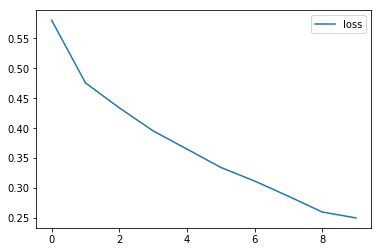

In [23]:
history = sevensModel.fit(X_train, y_train, class_weight= {0:1.27977484, 1:3.8534047, 2:0.510438}, epochs=10, callbacks=[plot_losses])

In [25]:
predY = classif_report(sevensModel)

              precision    recall  f1-score   support

           0       0.71      0.91      0.80      3368
           1       0.40      0.51      0.45      1127
           2       0.89      0.76      0.82      8464

   micro avg       0.78      0.78      0.78     12959
   macro avg       0.67      0.72      0.69     12959
weighted avg       0.80      0.78      0.78     12959



В общем и целом результаты стали хуже. Попробую понизить вес класса комментов к комментам, чтоб не случался такой сильный перекос.

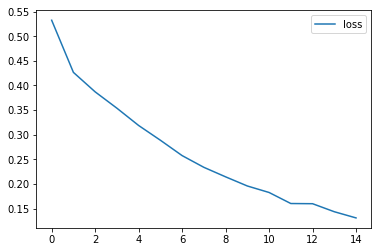

In [28]:
history = sevensModel.fit(X_train, y_train, class_weight= {0:1.27977484, 1:2.8534047, 2:0.510438}, epochs=15, callbacks=[plot_losses])

In [29]:
predY = classif_report(sevensModel)

              precision    recall  f1-score   support

           0       0.75      0.87      0.81      3368
           1       0.42      0.49      0.45      1127
           2       0.88      0.80      0.84      8464

   micro avg       0.79      0.79      0.79     12959
   macro avg       0.68      0.72      0.70     12959
weighted avg       0.80      0.79      0.80     12959



То есть веса здесь особой пользы не приносят. Комменты второго уровня распознаются чуть лучше, но за счет того, что остальные тексты распознаются хуже.